# Behaviour Cloning Journey — Passive Walker  

This notebook is a concise, step-by-step “story” of how we replace hand-written FSM controllers with neural networks.  
We start with the **hip-only MSE** variant and leave placeholders for the remaining experiments:

| Section | Variant | What changes |
|---------|---------|--------------|
| 1 | **Hip-only MSE** | collect hip labels, 1-D MLP |
| 2 | Knee-only MSE | label = both knees, 2×1-D MLP |
| 3 | Hip + Knee MSE | label = (hip, kneeL, kneeR), 3-D MLP |
| 4 | Alt. losses | Huber / L1 on hip |

Each variant repeats the same four mini-steps:

1. Collect FSM demo data  
2. Train a small MLP (behaviour cloning)  
3. Visualise label distribution, loss curve, prediction quality  
4. Do a short GUI roll-out  


## 1 Setup & Imports

In [1]:
from pathlib import Path
import numpy as np
import jax, jax.numpy as jnp
import optax, equinox as eqx
import pickle

from passive_walker.constants            import XML_PATH, BC_DATA
from passive_walker.envs.mujoco_fsm_env   import PassiveWalkerEnv
from passive_walker.bc.plotters           import plot_label_hist, plot_loss_curve, plot_pred_vs_true
from passive_walker.controllers.nn.hip_nn import HipController
from passive_walker.bc.hip_mse.train      import train_nn_controller

print("Repo ready — model XML →", XML_PATH)

Repo ready — model XML → /home/yunusdanabas/ENS492/passive_walker_rl/passiveWalker_model.xml


### Optional — choose CPU / GPU for this notebook

In [2]:
# Run once; change to True to force GPU if available
USE_GPU_NOTEBOOK = False            # ← flip anytime
import os, jax
os.environ["JAX_PLATFORM_NAME"] = "gpu" if USE_GPU_NOTEBOOK else "cpu"
print("Running on:", jax.default_backend())

Running on: cpu


## 2 Hip‐only MSE   
### 2.1 Collect a mini demo set  
The demo collection uses FSM‐only hip control in MuJoCo.  

Collected obs (20000, 11), labels (20000, 1)


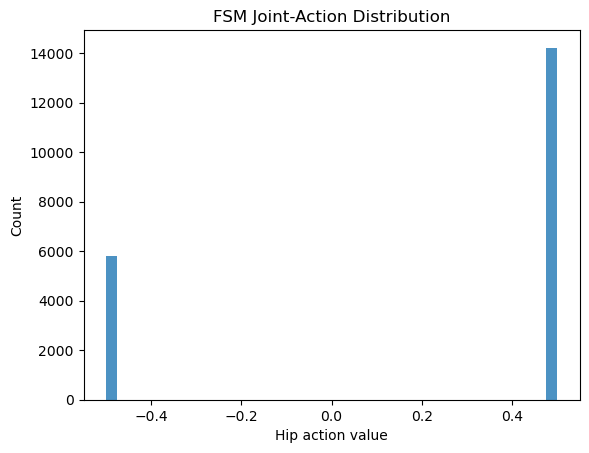

In [3]:
from passive_walker.bc.hip_mse.collect import collect_demo_data

DEMO_STEPS = 20_000

env_demo = PassiveWalkerEnv(
    xml_path=str(XML_PATH),
    simend=30,
    use_nn_for_hip=False,
    use_gui=False
)
obs, labels = collect_demo_data(env_demo, num_steps=DEMO_STEPS)
env_demo.close()

print(f"Collected obs {obs.shape}, labels {labels.shape}")
plot_label_hist(np.array(labels))

### 2.2 Train a MLP 
(For a full run, use the CLI script in `bc/hip_mse/run_pipeline.py`.)

[train] epoch 00  loss=0.0564
[train] epoch 01  loss=0.0436
[train] epoch 02  loss=0.0394
[train] epoch 03  loss=0.0367
[train] epoch 04  loss=0.0358
[train] epoch 05  loss=0.0344
[train] epoch 06  loss=0.0324
[train] epoch 07  loss=0.0316
[train] epoch 08  loss=0.0316
[train] epoch 09  loss=0.0285
[train] epoch 10  loss=0.0281
[train] epoch 11  loss=0.0263
[train] epoch 12  loss=0.0252
[train] epoch 13  loss=0.0242
[train] epoch 14  loss=0.0233
[train] epoch 15  loss=0.0218
[train] epoch 16  loss=0.0209
[train] epoch 17  loss=0.0207
[train] epoch 18  loss=0.0193
[train] epoch 19  loss=0.0185
[train] epoch 20  loss=0.0179
[train] epoch 21  loss=0.0173
[train] epoch 22  loss=0.0176
[train] epoch 23  loss=0.0160
[train] epoch 24  loss=0.0153
[train] epoch 25  loss=0.0160
[train] epoch 26  loss=0.0144
[train] epoch 27  loss=0.0164
[train] epoch 28  loss=0.0161
[train] epoch 29  loss=0.0127
[train] epoch 30  loss=0.0143
[train] epoch 31  loss=0.0147
[train] epoch 32  loss=0.0126
[train] ep

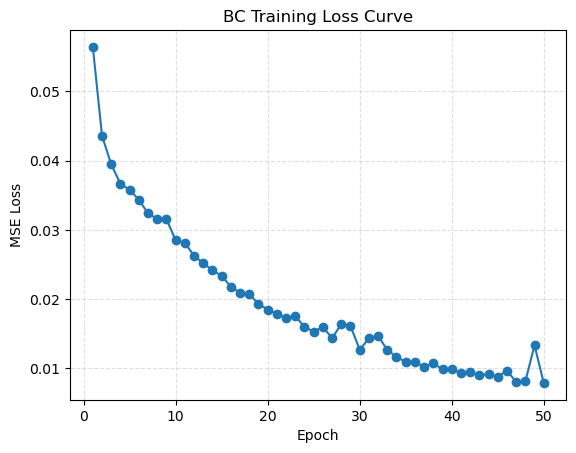

In [4]:
from passive_walker.bc.hip_mse.train import train_nn_controller

# Hyper-parameters
EPOCHS, BATCH, LR = 50, 32, 1e-4

# Initialize model & optimizer
hip_model     = HipController(input_size=obs.shape[1], hidden_size=128)
optimizer = optax.adam(LR)

# Train (dont auto-plot — we’ll plot below)
hip_model, loss_hist = train_nn_controller(
    nn_controller=hip_model,
    optimizer=optimizer,
    demo_obs=obs,
    demo_labels=labels,
    num_epochs=EPOCHS,
    batch_size=BATCH,
    plot_loss=False,    # set True if you want to auto-save the plot to DATA_DIR
)

# Plot the training loss curve
plot_loss_curve(loss_hist)

### 2.3 Scatter: prediction vs ground-truth

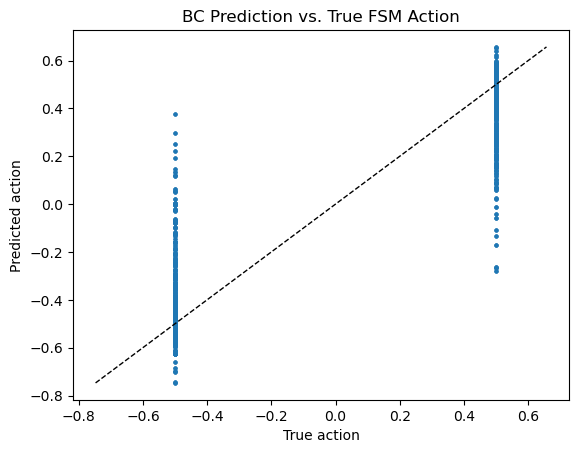

In [5]:
preds = np.array([hip_model(jnp.array(o)) for o in obs])
plot_pred_vs_true(np.array(labels), preds)

### 2.4 GUI roll-out (10 s)
Run only on a machine with a display.

In [6]:
import glfw
env_test_hip = PassiveWalkerEnv(
    xml_path=str(XML_PATH),
    simend=10.0,
    use_nn_for_hip=True,
    use_gui=True
)
obs, done, total = env_test_hip.reset(), False, 0.0
while not done and not glfw.window_should_close(env_test_hip.window):
    act = np.array(hip_model(jnp.array(obs)))
    obs, rew, done, _ = env_test_hip.step(act)
    total += rew
    env_test_hip.render()
env_test_hip.close()
print("GUI rollout total reward:", total)

GUI rollout total reward: 4396.763935204108


## 3 Knee-only MSE  
We now repeat the pipeline, but recording **left & right knee actions**.

Collected knee demos: obs (20000, 11), labels (20000, 2)


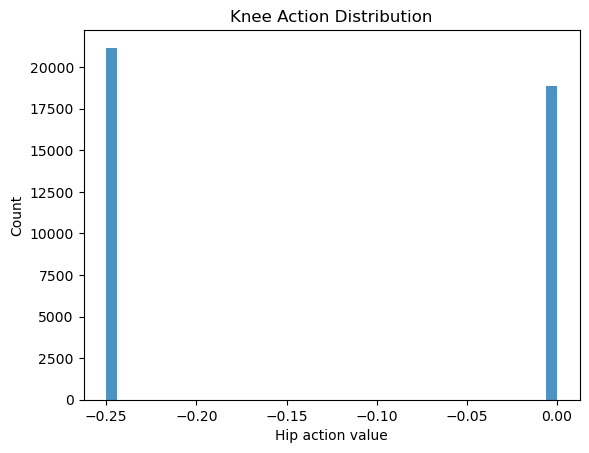

In [7]:
from passive_walker.bc.knee_mse        import set_device, XML_PATH as K_XML
from passive_walker.bc.knee_mse.collect import collect_demo_data
from passive_walker.envs.mujoco_fsm_env  import PassiveWalkerEnv

# 1) Configure CPU/GPU
set_device(USE_GPU_NOTEBOOK)

# 2) Collect demos
DEMO_STEPS_KNEE = 20_000
env_knee = PassiveWalkerEnv(
    xml_path=K_XML,
    simend=30,
    use_nn_for_hip=False,
    use_nn_for_knees=False,
    use_gui=False
)
obs_k, labels_k = collect_demo_data(env_knee, num_steps=DEMO_STEPS_KNEE)
env_knee.close()

# 3) Report & visualize
print(f"Collected knee demos: obs {obs_k.shape}, labels {labels_k.shape}")
plot_label_hist(np.array(labels_k), title="Knee Action Distribution")

### 3.2 Train a MLP (knee)

[train] epoch 00  loss=0.0034
[train] epoch 01  loss=0.0030
[train] epoch 02  loss=0.0025
[train] epoch 03  loss=0.0025
[train] epoch 04  loss=0.0024
[train] epoch 05  loss=0.0022
[train] epoch 06  loss=0.0023
[train] epoch 07  loss=0.0019
[train] epoch 08  loss=0.0018
[train] epoch 09  loss=0.0018
[train] epoch 10  loss=0.0015
[train] epoch 11  loss=0.0016
[train] epoch 12  loss=0.0015
[train] epoch 13  loss=0.0013
[train] epoch 14  loss=0.0013
[train] epoch 15  loss=0.0012
[train] epoch 16  loss=0.0014
[train] epoch 17  loss=0.0012
[train] epoch 18  loss=0.0011
[train] epoch 19  loss=0.0010
[train] epoch 20  loss=0.0010
[train] epoch 21  loss=0.0010
[train] epoch 22  loss=0.0010
[train] epoch 23  loss=0.0009
[train] epoch 24  loss=0.0009
[train] epoch 25  loss=0.0009
[train] epoch 26  loss=0.0009
[train] epoch 27  loss=0.0009
[train] epoch 28  loss=0.0008
[train] epoch 29  loss=0.0008
[train] epoch 30  loss=0.0008
[train] epoch 31  loss=0.0008
[train] epoch 32  loss=0.0008
[train] ep

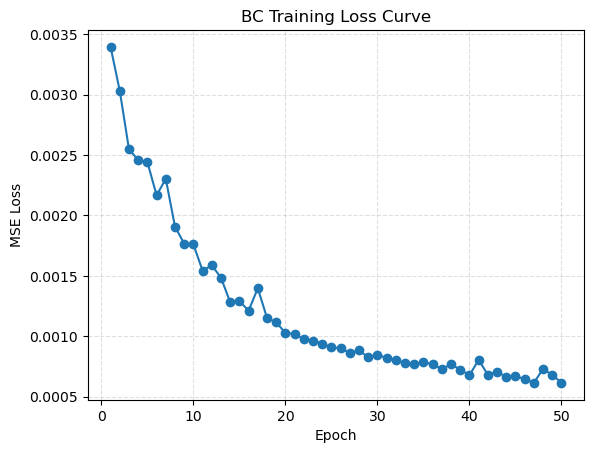

In [8]:
from passive_walker.controllers.nn.knee_nn import KneeController
from passive_walker.bc.knee_mse.train import train_nn_controller as train_knee_controller

# Hyper-parameters
EPOCHS_K, BATCH_K, LR_K = 50, 32, 1e-4

# Initialize model & optimizer
knee_model = KneeController(input_size=obs_k.shape[1], hidden_size=128)
knee_opt   = optax.adam(LR_K)

# Train (plot_loss=False means we’ll plot manually below)
knee_model, knee_loss_hist = train_knee_controller(
    nn_controller=knee_model,
    optimizer=knee_opt,
    demo_obs=obs_k,
    demo_labels=labels_k,
    num_epochs=EPOCHS_K,
    batch_size=BATCH_K,
    plot_loss=False,
)

# Plot the knee training loss curve
plot_loss_curve(knee_loss_hist)

### 3.3 Prediction vs Ground-Truth Scatter (Knee)

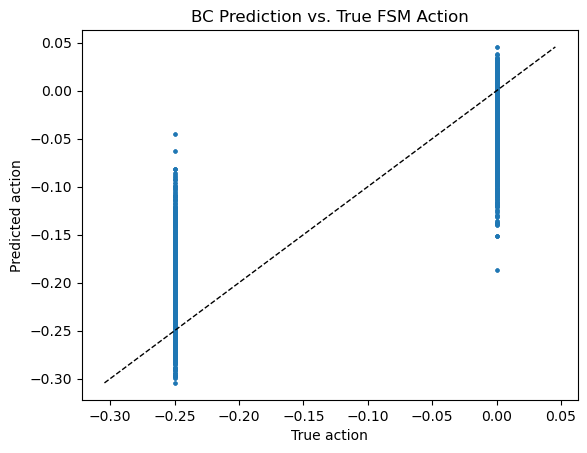

In [9]:
preds_k = np.array([knee_model(jnp.array(o)) for o in obs_k])
plot_pred_vs_true(np.array(labels_k), preds_k)

In [10]:
import glfw
env_test_knee = PassiveWalkerEnv(
    xml_path=str(XML_PATH),
    simend=10.0,
    use_nn_for_hip=False,
    use_nn_for_knees=True,
    use_gui=True
)
obs, done, total = env_test_knee.reset(), False, 0.0
while not done and not glfw.window_should_close(env_test_knee.window):
    act = np.array(knee_model(jnp.array(obs)))
    obs, rew, done, _ = env_test_knee.step(act)
    total += rew
    env_test_knee.render()
env_test_knee.close()
print("GUI rollout total reward:", total)

GUI rollout total reward: 2560.6787922731105


## 4 Hip + Knee MSE  

We now train one MLP to predict **all three** actuator commands (hip, left knee, right knee).

### 4.1 Collect a mini demo set

Collected hip+knee demos: obs (20000, 11), labels (20000, 3)


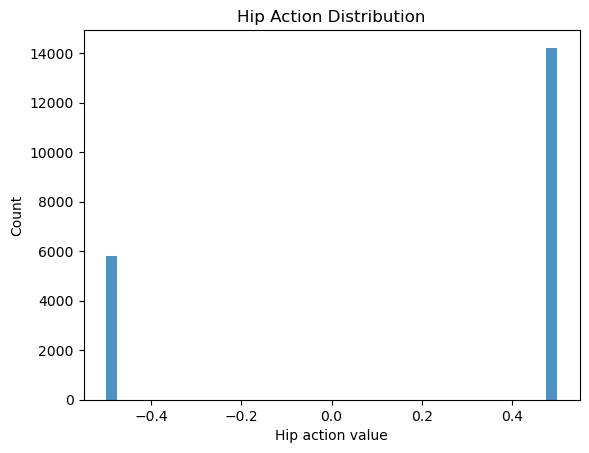

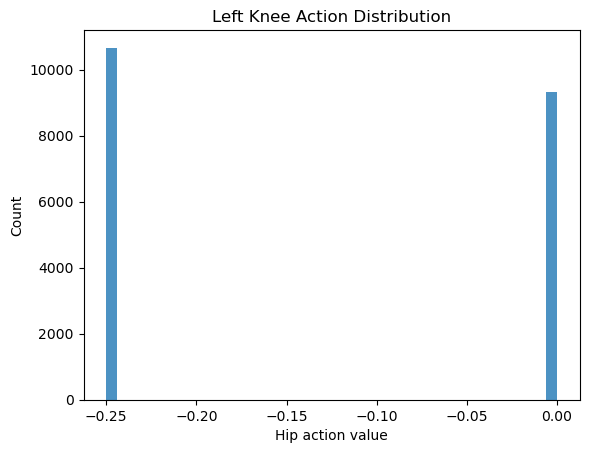

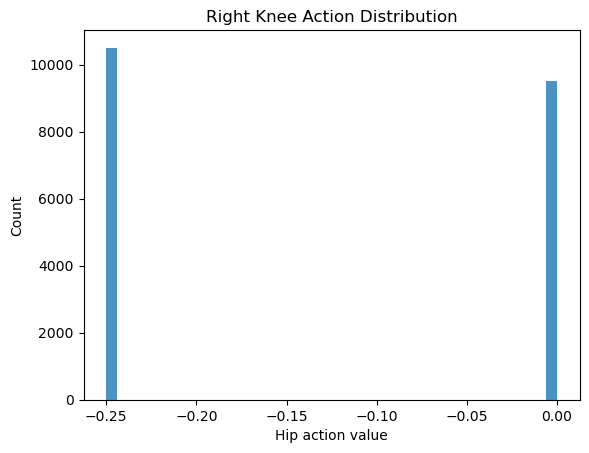

In [11]:
from passive_walker.bc.hip_knee_mse import set_device, XML_PATH
from passive_walker.bc.hip_knee_mse.collect import collect_demo_data
from passive_walker.envs.mujoco_fsm_env import PassiveWalkerEnv

# 1) CPU/GPU toggle
set_device(USE_GPU_NOTEBOOK)

# 2) Collect demos
DEMO_STEPS_HK = 20_000

env_hk = PassiveWalkerEnv(
    xml_path=str(XML_PATH),
    simend=30,
    use_nn_for_hip=False,
    use_nn_for_knees=False,
    use_gui=False
)
obs_hk, labels_hk = collect_demo_data(env_hk, num_steps=DEMO_STEPS_HK)
env_hk.close()

# 3) Report & visualize
print(f"Collected hip+knee demos: obs {obs_hk.shape}, labels {labels_hk.shape}")
plot_label_hist(np.array(labels_hk[:,0]), title="Hip Action Distribution")
plot_label_hist(np.array(labels_hk[:,1]), title="Left Knee Action Distribution")
plot_label_hist(np.array(labels_hk[:,2]), title="Right Knee Action Distribution")

### 4.2 Train a MLP

[train] epoch 01  loss=0.0144
[train] epoch 02  loss=0.0115
[train] epoch 03  loss=0.0118
[train] epoch 04  loss=0.0072
[train] epoch 05  loss=0.0067
[train] epoch 06  loss=0.0055
[train] epoch 07  loss=0.0051
[train] epoch 08  loss=0.0032
[train] epoch 09  loss=0.0032
[train] epoch 10  loss=0.0031
[train] epoch 11  loss=0.0030
[train] epoch 12  loss=0.0038
[train] epoch 13  loss=0.0036
[train] epoch 14  loss=0.0022
[train] epoch 15  loss=0.0024
[train] epoch 16  loss=0.0018
[train] epoch 17  loss=0.0024
[train] epoch 18  loss=0.0028
[train] epoch 19  loss=0.0029
[train] epoch 20  loss=0.0049


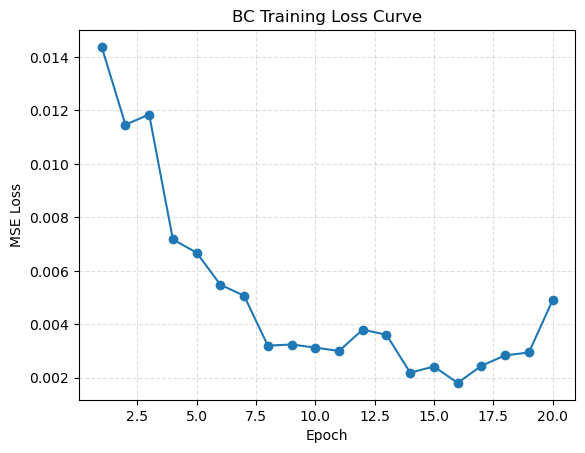

In [12]:
from passive_walker.controllers.nn.hip_knee_nn import HipKneeController
from passive_walker.bc.hip_knee_mse.train import train_nn_controller as train_hk

EPOCHS_HK, BATCH_HK, LR_HK = 20, 32, 1e-3

# Initialize model & optimizer
hk_model = HipKneeController(input_size=obs_hk.shape[1], hidden_size=128)
hk_opt   = optax.adam(LR_HK)

# Train & record loss
hk_model, hk_loss_hist = train_hk(
    model=hk_model,
    optimizer=hk_opt,
    obs=obs_hk,
    labels=labels_hk,
    epochs=EPOCHS_HK,
    batch=BATCH_HK
)

# Plot loss curve
plot_loss_curve(hk_loss_hist)

### 4.3 Prediction vs Ground-Truth  
Scatter for each action channel.

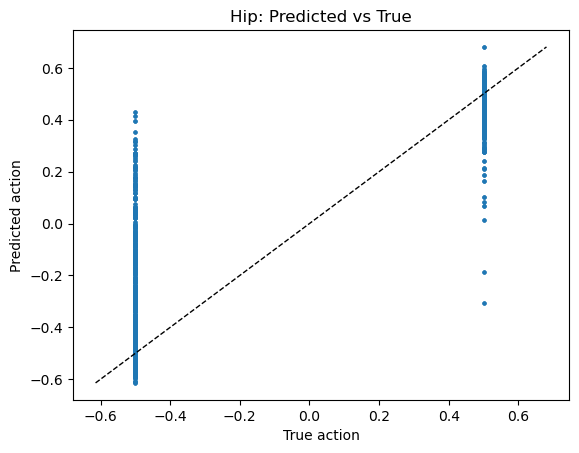

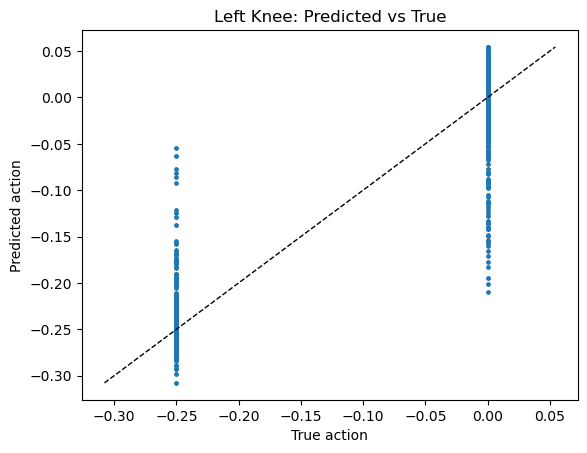

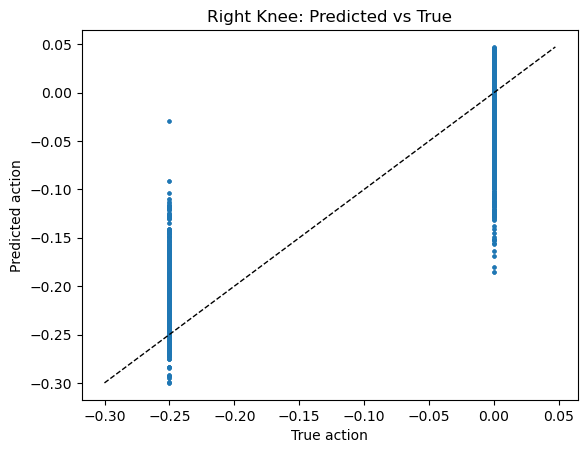

In [13]:
preds_hk = np.stack([np.array(hk_model(jnp.array(o))) for o in obs_hk], axis=0)

# Hip channel
plot_pred_vs_true(
    true=labels_hk[:,0],
    pred=preds_hk[:,0],
    title="Hip: Predicted vs True"
)

# Left knee channel
plot_pred_vs_true(
    true=labels_hk[:,1],
    pred=preds_hk[:,1],
    title="Left Knee: Predicted vs True"
)

# Right knee channel
plot_pred_vs_true(
    true=labels_hk[:,2],
    pred=preds_hk[:,2],
    title="Right Knee: Predicted vs True"
)

### 4.4 GUI Roll-Out (10 s)  
Verify both hip and knees are now controlled by the MLP.

In [14]:
env_test_hipKnee = PassiveWalkerEnv(
    xml_path=str(XML_PATH),
    simend=10.0,
    use_nn_for_hip=True,
    use_nn_for_knees=True,
    use_gui=True
)
obs, done, total = env_test_hipKnee.reset(), False, 0.0
while not done and not glfw.window_should_close(env_test_hipKnee.window):
    act = np.array(hk_model(jnp.array(obs)))   # 3-vector
    obs, r, done, _ = env_test_hipKnee.step(act)
    total += r
    env_test_hipKnee.render()
env_test_hipKnee.close()
print("Hip+Knee GUI reward:", total)

Hip+Knee GUI reward: 1970.2513803177176


## 5 Alternative-Loss Comparison

In this section we will:

1. Re-collect a small hip+knee demo set  
2. Train four variants (MSE, Huber, L1, Combined) **in-notebook**  
3. Plot their loss curves side-by-side  
4. Run a short GUI rollout for each and compare total reward  
5. Play out the best variant for a longer test  


In [ ]:
# nb-cell
# 5.1 Setup & Imports
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from mujoco.glfw import glfw

from passive_walker.envs.mujoco_fsm_env import PassiveWalkerEnv
from passive_walker.controllers.nn.hip_knee_nn import HipKneeController
from passive_walker.bc.hip_knee_alternatives import set_device, XML_PATH
from passive_walker.bc.hip_knee_alternatives.collect import collect_demo_data

import passive_walker.bc.hip_knee_alternatives.train_mse    as mse_mod
import passive_walker.bc.hip_knee_alternatives.train_huber  as huber_mod
import passive_walker.bc.hip_knee_alternatives.train_l1     as l1_mod
import passive_walker.bc.hip_knee_alternatives.train_combined as comb_mod

# Toggle GPU if desired
USE_GPU_NOTEBOOK = False
set_device(USE_GPU_NOTEBOOK)

# Hyperparameters
DEMO_STEPS   = 5_000
EPOCHS       = 30
BATCH_SIZE   = 32
HIDDEN_SIZE  = 128
LR           = 1e-3
SIM_DURATION = 10.0
SEED         = 42

# Combined-loss weights
ALPHA_SYM    = 0.1
BETA_SMOOTH  = 0.1
GAMMA_ENERGY = 0.01
WEIGHT_DECAY = 1e-4

np.random.seed(SEED)